In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from libertem import api
from libertem.job.raw import PickFrameJob
from libertem.common.slice import Slice

In [4]:
ctx = api.Context()

In [5]:
ds = ctx.load(
    "blo",
    path='C:\\Users\\weber\\ownCloud\\Projects\\Open Pixelated STEM framework\\Data\\3rd-Party Datasets\\Glasgow\\10 um 110.blo',
    tileshape=(1,8, 144,144)
)
(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = (detector_y, detector_x)

In [6]:

# pick two full frames, starting at scan position (0, 0)
get_sample_frame = PickFrameJob(dataset=ds, slice_=Slice(origin=(60, 75, 0, 0), shape=(1, 1, detector_y, detector_x)))
res = ctx.run(get_sample_frame)  # res is a numpy array with shape as specified above
sample_frame = res[0,0]

In [7]:
def selector(buf, center, radius1, radius2):
    (x, y) = center
    (max_y, max_x) = buf.shape
    radius1_2 = radius1**2
    radius2_2 = radius2**2
    inner = []
    outer = []
    bounding_radius = max(radius1, radius2)
    # calculate bounding box to save time
    left_x = int(max(0, np.floor(x - bounding_radius)))
    right_x = int(min(max_x - 1, np.ceil(x + bounding_radius)))
    up_y = int(max(0, np.floor(y - bounding_radius)))
    down_y = int(min(max_y - 1 , np.ceil(y + bounding_radius)))
    
    # register which pixels are in the inner resp. outer region of the peak selector
    for i in range(left_x, right_x + 1):
        for j in range(up_y, down_y + 1):
            if ((i-x)**2 + (j-y)**2 < radius1_2): 
                inner.append((i, j))
            elif ((i-x)**2 + (j-y)**2 < radius2_2):
                outer.append((i,j))
    # set inner ones to 1            
    for (i, j) in inner:
        buf[j, i] = 1
    # if we have any outer pixels:
    # set them to a negative number so that the total sum around a peak is 0
    # That means applying this mask to a constant background yields 0
    if (len(outer) > 0):
        outer_num = len(inner) / len(outer)
        for (i, j) in outer:
            buf[j, i] = -outer_num

# "count" parameter includes the corner peaks
def peak_grid(upper_left, upper_right, lower_left, count_x, count_y, skip=[]):
    coords = []
    upper_left = np.array(upper_left)
    upper_right = np.array(upper_right)
    lower_left = np.array(lower_left)
    # calculate the grid positions
    for x in range(count_x):
        for y in range(count_y):
            if (x, y) in skip:
                continue
            start = upper_left
            delta_a = (upper_right - upper_left)*x/(count_x - 1)
            delta_b = (lower_left - upper_left)*y/(count_y - 1)
            coords.append(start + delta_a + delta_b)
    return coords

            
def super_peaks():
    buf = np.zeros(mask_shape)
    # inner and outer radius of peak selector
    inner = 2
    outer = 5
    # instead of selecting and typing all coordinates of the peaks, 
    # we calculate a grid from three corner points and the number of peaks in X and y
    coords = peak_grid(
        (8.1, 45.6),
        (91.1, 23.21),
        (28.8, 129.5),
        8,
        6
    )
    # Apply the peak positions to the mask
    for (x, y) in coords:
        selector(buf, (x, y), inner, outer)
    return buf

def base_peaks():    
    buf = np.zeros(mask_shape)
    inner = 2
    outer = 5
    coords = peak_grid(
        (11.1, 35.4),
        (107.7, 11.4),
        (36.5, 135.8),
        9,
        7,
        # skip the zero-order peak
        skip=[(4, 3)]
    )
    for (x, y) in coords:
        selector(buf, (x, y), inner, outer)
    return buf

<IPython.core.display.Javascript object>


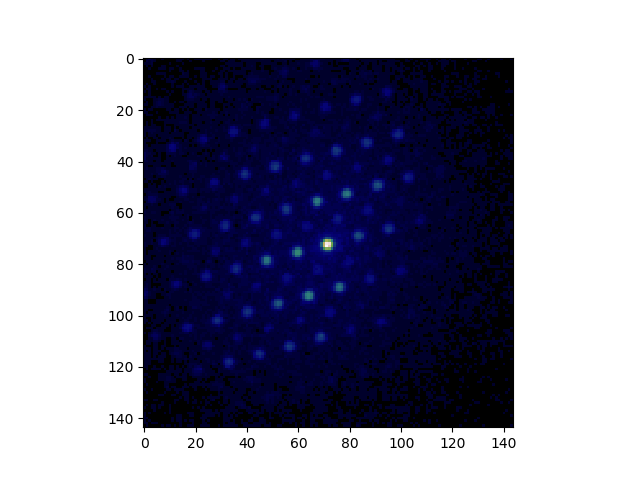

<IPython.core.display.Javascript object>


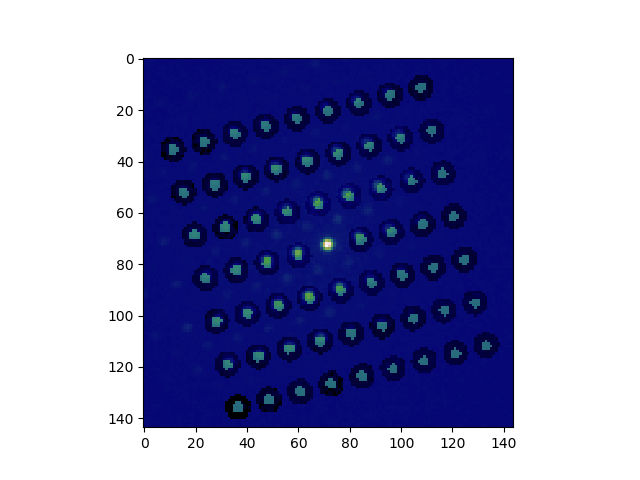

<IPython.core.display.Javascript object>


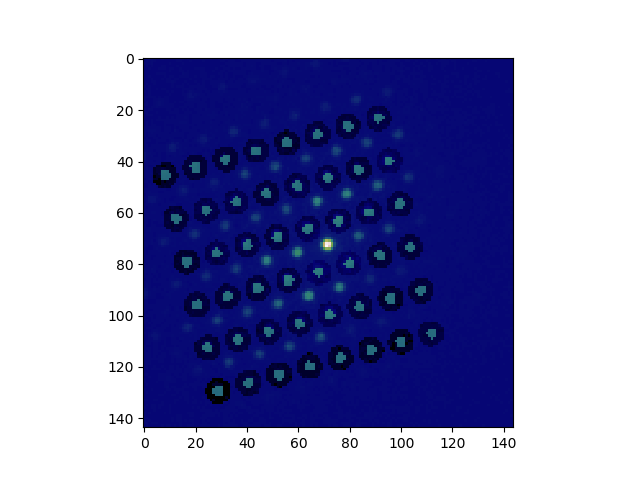

In [8]:
# Check if we got the selectors at the right spot:
# Sample frame
fig, axes = plt.subplots()
axes.imshow(sample_frame/50, cmap=cm.gist_earth)
# superimposed with base peaks
fig, axes = plt.subplots()
axes.imshow(base_peaks() + sample_frame/50, cmap=cm.gist_earth)
# superimposed with superlattice peaks
fig, axes = plt.subplots()
axes.imshow(super_peaks() + sample_frame/50, cmap=cm.gist_earth)

In [9]:
job = ctx.create_mask_job(factories=[super_peaks, base_peaks], dataset=ds)

In [10]:
%%time
result = ctx.run(job)

Wall time: 2.08 s


<IPython.core.display.Javascript object>


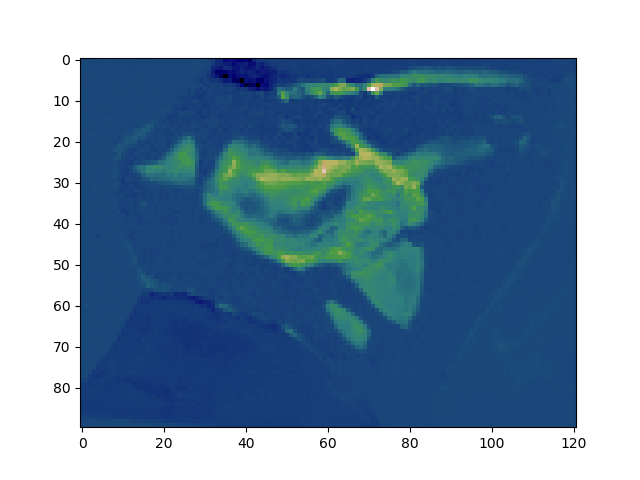

In [11]:
fig, axes = plt.subplots()
axes.imshow(result[0], cmap=cm.gist_earth)

<IPython.core.display.Javascript object>


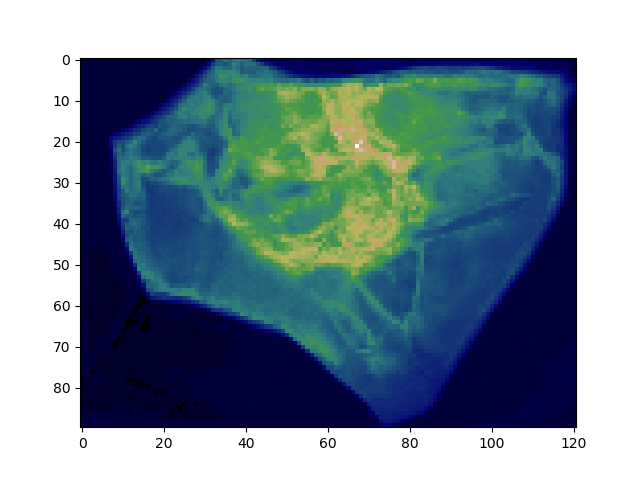

In [12]:
fig, axes = plt.subplots()
axes.imshow(result[1], cmap=cm.gist_earth)